# Lab 5 Project (Wine DataSet)
Jason Ballard
11 April 2025



## Section 0.  Import depedencies

In [1]:
# all imports get moved to the top - import each only once
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tabulate

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)


print("Version:", sklearn.__version__)
print("Location:", sklearn.__file__)

Version: 1.6.1
Location: c:\Users\balla\Projects\applied-ml-jballard\.venv\Lib\site-packages\sklearn\__init__.py


In [2]:
# Create folder if it doesn't exist
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

## Section 1 Load and Inspect the Data 

In [3]:
# Load Wine Dataset dataset
df = pd.read_csv("winequality.csv", sep=",")
print(df.head())
print(df.info())

# Load spiral dataset
spiral = pd.read_csv("spiral.csv")

# Display basic information
spiral.info()

# Display first few rows
print(spiral.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

## Section 2. Prepare the Data 

In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

print(df.columns)

Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

Duplicate rows: 0
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id'],
      dtype='object')


In [5]:
# Create a new feature 'quality_label' based on the 'quality' column
# Define the function to convert quality to label and numeric value
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_label"] = df["quality"].apply(quality_to_label)

def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df["quality_numeric"] = df["quality"].apply(quality_to_number)

Correlation matrix:
                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.250728     0.673157   
volatile acidity          -0.250728          1.000000    -0.544187   
citric acid                0.673157         -0.544187     1.000000   
residual sugar             0.171831         -0.005751     0.175815   
chlorides                  0.107889          0.056336     0.245312   
free sulfur dioxide       -0.164831         -0.001962    -0.057589   
total sulfur dioxide      -0.110628          0.077748     0.036871   
density                    0.681501          0.016512     0.375243   
pH                        -0.685163          0.221492    -0.546339   
sulphates                  0.174592         -0.276079     0.331232   
alcohol                   -0.075055         -0.203909     0.106250   
quality                    0.121970         -0.407394     0.240821   
Id                        -0.275826         -0.007892    -0.139011   


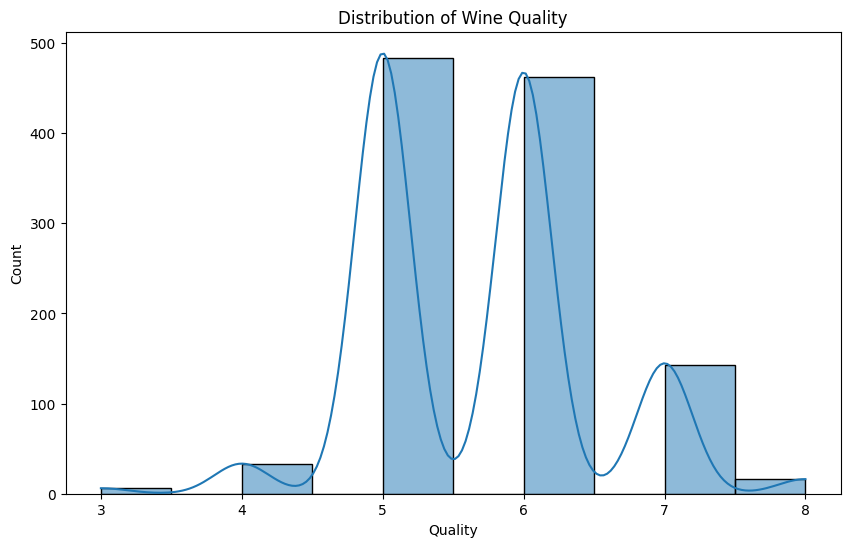

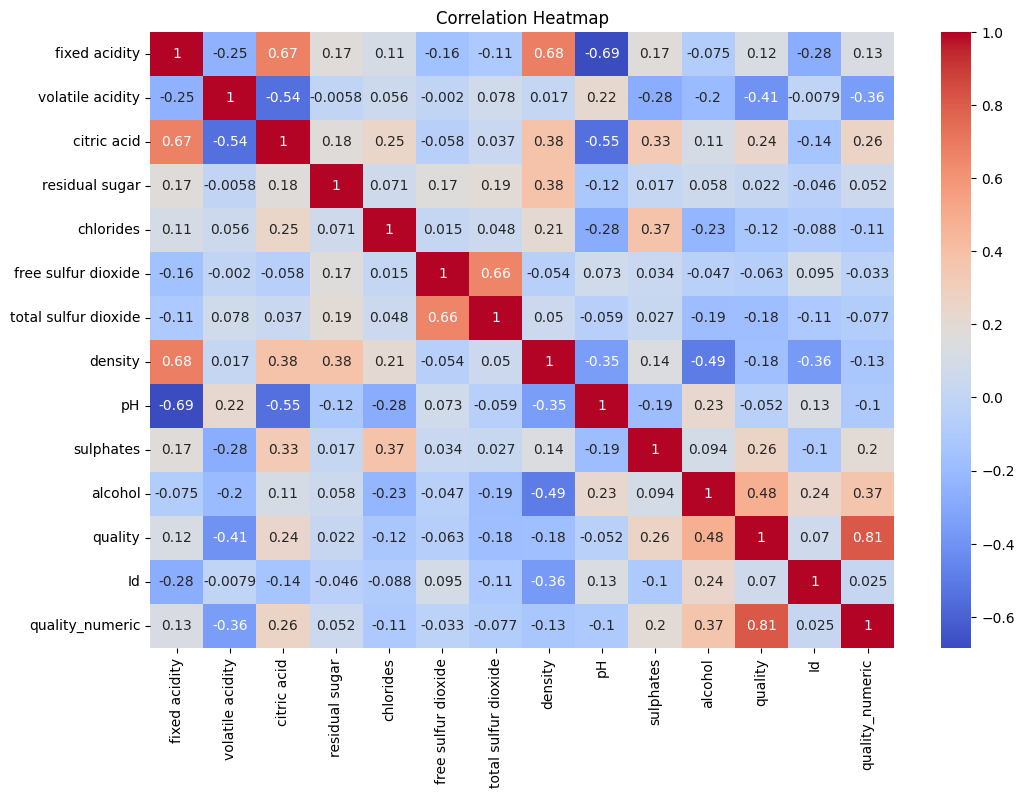

In [6]:
# Quick correlation check
print("Correlation matrix:")
print(df.corr(numeric_only=True))
print("\nCorrelation with quality:")
print(df.corr(numeric_only=True)["quality"].sort_values(ascending=False))

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df["quality"], bins=10, kde=True)
plt.title("Distribution of Wine Quality")
plt.savefig(os.path.join(output_dir, "quality_distribution.png"))
plt.xlabel("Quality")

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
plt.show()

<!-- ### Reflection 2.3

1. Why might family size be a useful feature for predicting survival? famil;y size is a good prediction of survivalbility for the female and younger children of the families
2. Why convert categorical data to numeric?  the conversion allows computations to be run on the data. -->

# Section 3. Feature Selection and Justification

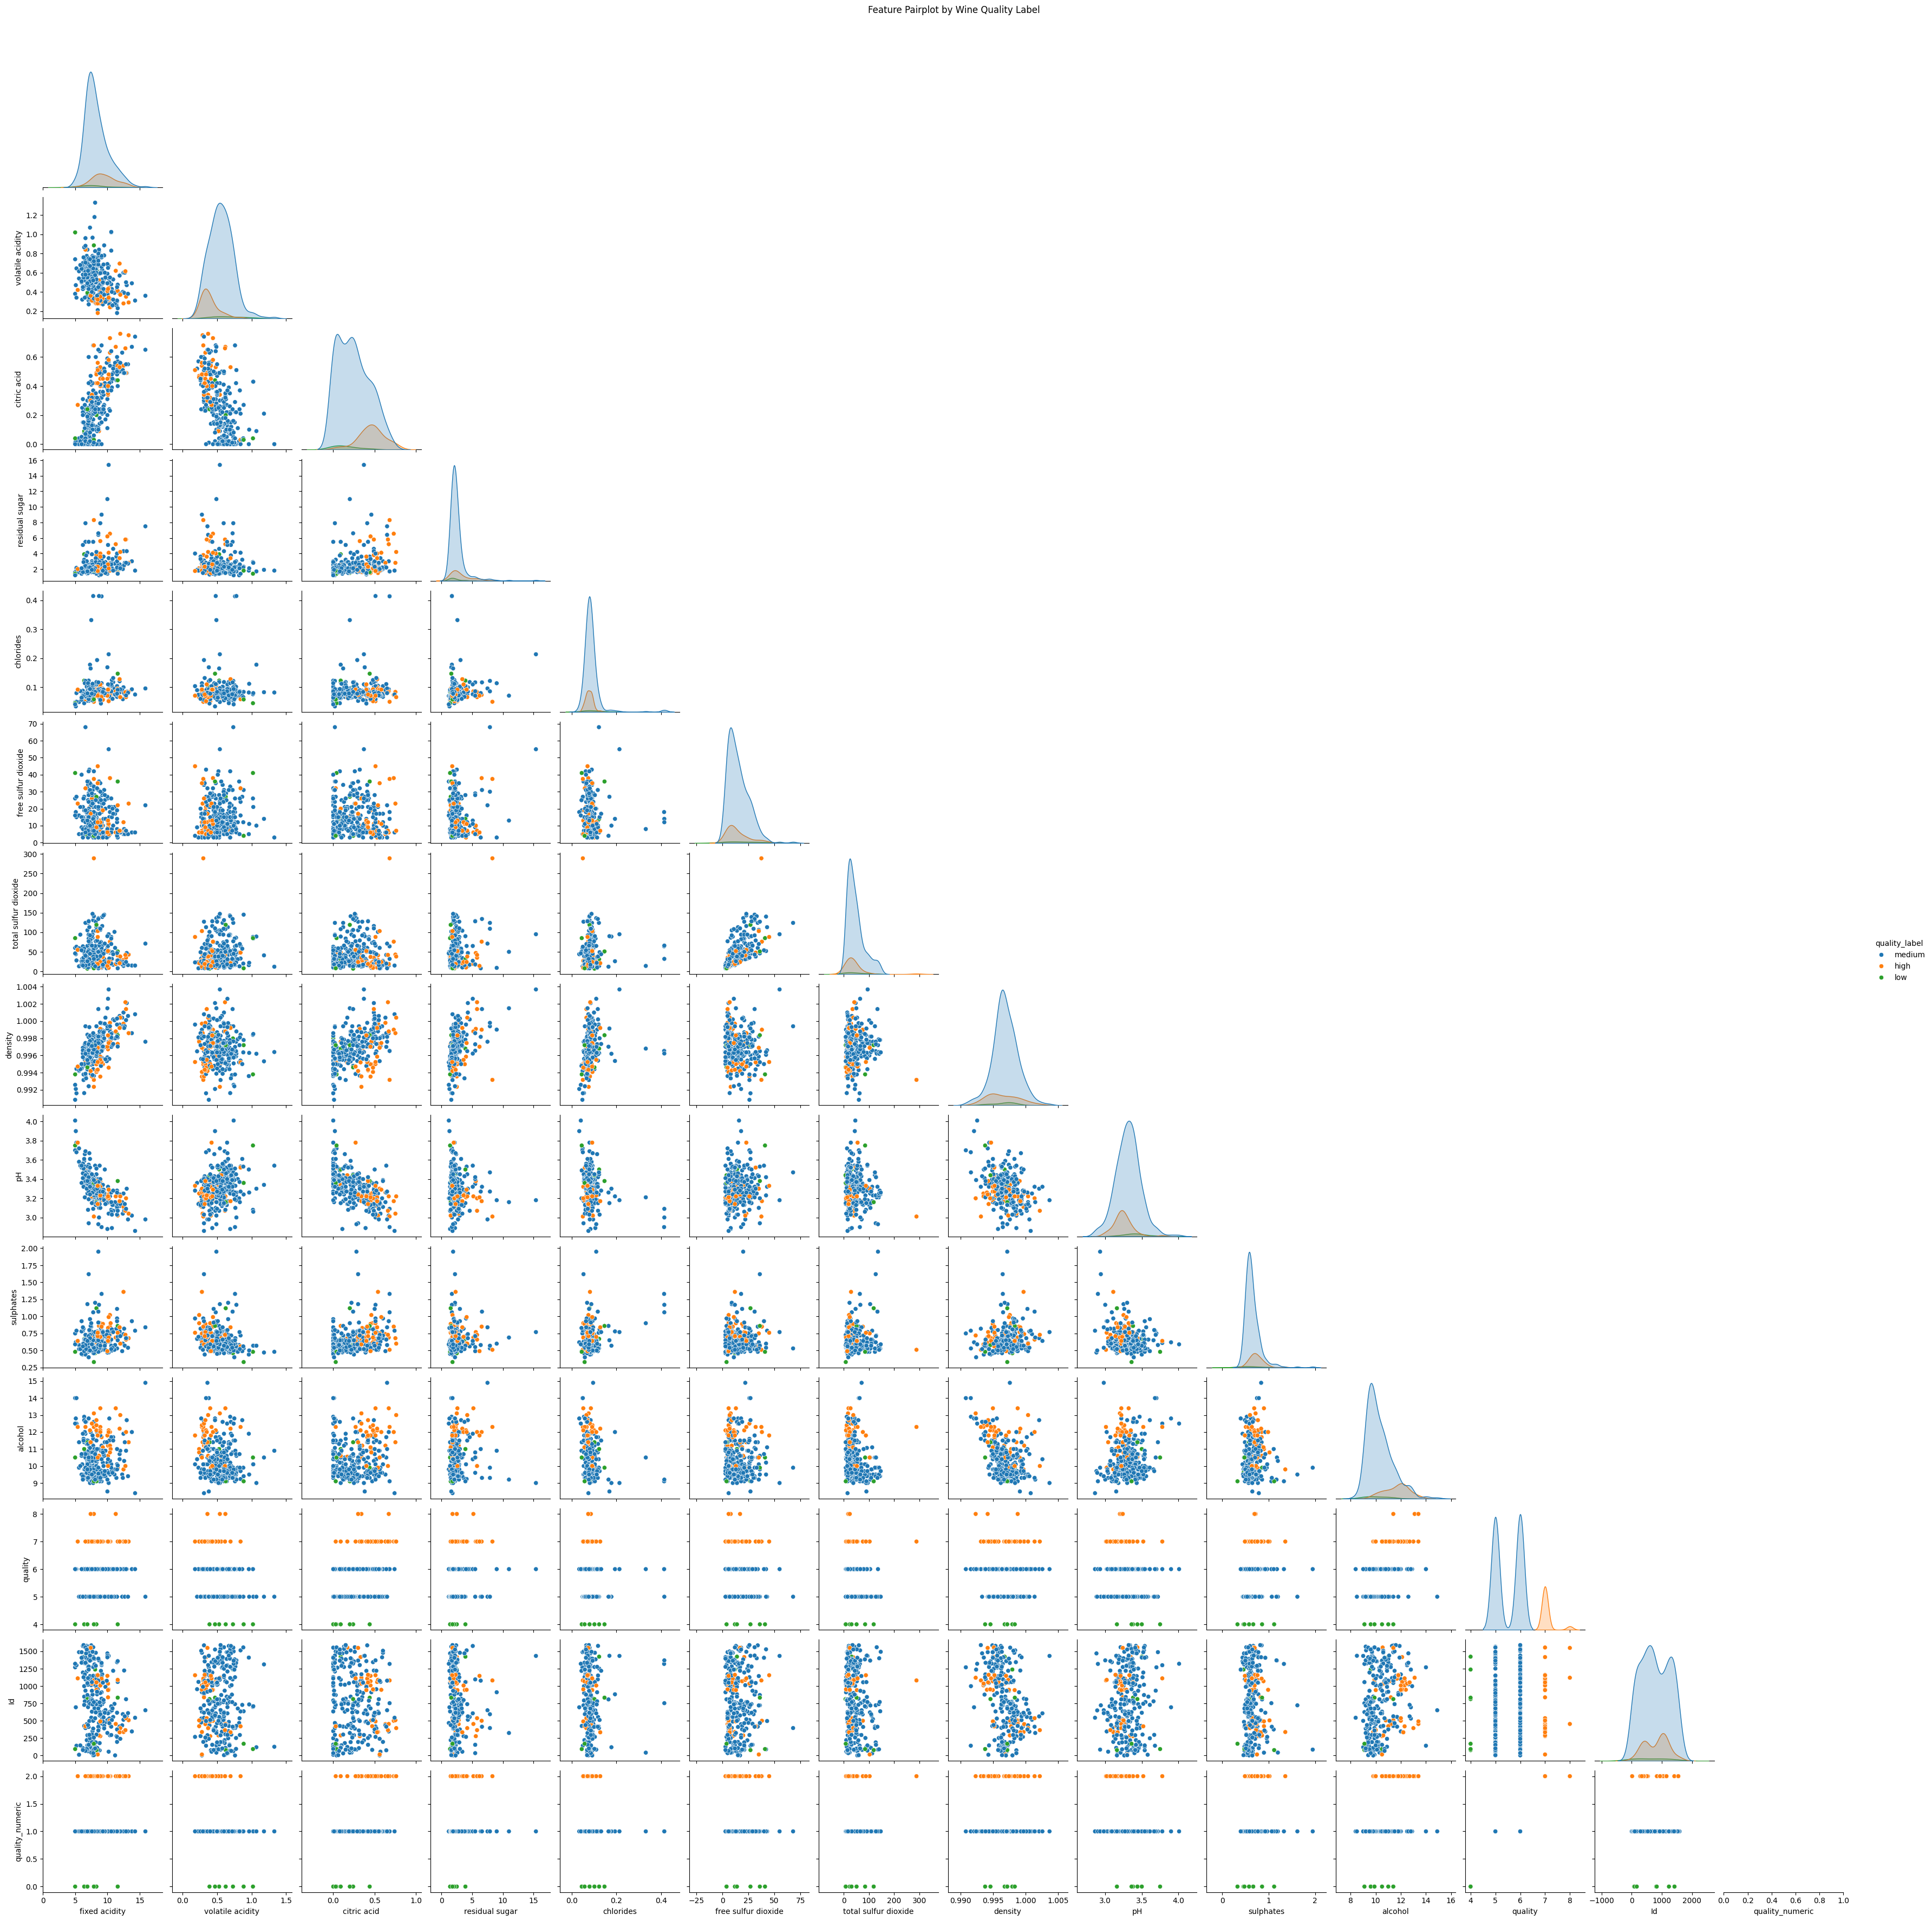

In [7]:
# Select features and target variable
# Drop the target variable and label columns from the features
# and keep only the numeric features
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])
y = df["quality_numeric"]

# Sample 300 rows
sample_df = df.sample(300, random_state=42)

# Target label for color
sns.pairplot(sample_df, hue="quality_label", diag_kind="kde", corner=True)
plt.suptitle("Feature Pairplot by Wine Quality Label", y=1.02)
plt.show()

# Section 4. Split the Data into Train and Test

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#Confirm the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Train labels distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test labels distribution:\n{y_test.value_counts(normalize=True)}")  

print("\nClass balance in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Training set size: 914
Testing set size: 229
Train labels distribution:
quality_numeric
1    0.827133
2    0.138950
0    0.033917
Name: proportion, dtype: float64
Test labels distribution:
quality_numeric
1    0.825328
2    0.139738
0    0.034934
Name: proportion, dtype: float64

Class balance in test set:
quality_numeric
1    0.825328
2    0.139738
0    0.034934
Name: proportion, dtype: float64


## Section 5. Evaluate Model Performance

In [9]:
# Helper function
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )

# Initialize results list
results = []


In [10]:
# Gradient Boosting
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# Voting Classifier (RF + LR + KNN)
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
        ("LR", LogisticRegression(max_iter=1000, random_state=42)),
        ("KNN", KNeighborsClassifier()),
    ],
    voting="soft"
)

evaluate_model(
    "Voting (RF + LR + KNN)",
    voting2,
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)



Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0   8   0]
 [  2 181   6]
 [  0  12  20]]
Train Accuracy: 0.9836, Test Accuracy: 0.8777
Train F1 Score: 0.9832, Test F1 Score: 0.8624

Voting (RF + LR + KNN) Results
Confusion Matrix (Test):
[[  0   8   0]
 [  0 187   2]
 [  0  27   5]]
Train Accuracy: 0.9070, Test Accuracy: 0.8384
Train F1 Score: 0.8849, Test F1 Score: 0.7869


c:\Users\balla\Projects\applied-ml-jballard\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Experiment with StandardScaler
# Voting Classifier (RF + LR + KNN) with StandardScaler
voting2_scaled = make_pipeline(
    StandardScaler(),
    VotingClassifier(
        estimators=[
            ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
            ("LR", LogisticRegression(max_iter=1000, random_state=42)),
            ("KNN", KNeighborsClassifier()),
        ],
        voting="soft",
    ),
)   

evaluate_model(
    "Voting (RF + LR + KNN) with StandardScaler",
    voting2_scaled,
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)



Voting (RF + LR + KNN) with StandardScaler Results
Confusion Matrix (Test):
[[  0   8   0]
 [  0 184   5]
 [  0  16  16]]
Train Accuracy: 0.9147, Test Accuracy: 0.8734
Train F1 Score: 0.8967, Test F1 Score: 0.8494


## Section 6. Compare Results

In [13]:
# Create DataFrame from results list
results_df = pd.DataFrame(results)

# Add generalization gap metrics
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Score Gap"] = results_df["Train F1"] - results_df["Test F1"]

# Sort by highest test accuracy
results_df_sorted = results_df.sort_values(by="Test Accuracy", ascending=False)

# Display the table
print("\n📊 Summary of All Models (Sorted by Test Accuracy):")
print(results_df_sorted.to_string(index=False))



📊 Summary of All Models (Sorted by Test Accuracy):
                                     Model  Train Accuracy  Test Accuracy  Train F1  Test F1  Accuracy Gap  F1 Score Gap
                   Gradient Boosting (100)        0.983589       0.877729  0.983241 0.862444      0.105859      0.120796
Voting (RF + LR + KNN) with StandardScaler        0.914661       0.873362  0.896727 0.849409      0.041298      0.047318
                    Voting (RF + LR + KNN)        0.907002       0.838428  0.884859 0.786858      0.068574      0.098001


## 6.1 Bar Chart of Test Accuracy and F1 Score